<a href="https://colab.research.google.com/github/Pashtetickus/Nornikel_prac/blob/main/torch_logreg_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание:


Перебор моделей, любой анализ сделать не успел, но как и хотелось попробовал поиграть с FE и вроде бы чуть улучшилось решение с деревом.
 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_curve

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
set_matplotlib_formats('svg')


def plot_confusion_matrix(targets,predictions, classes,
                          normalize=False, title='Confusion matrix',
                          figsize=(4, 4), cmap=plt.cm.Reds):

    conf_matrix = confusion_matrix(y_true=targets, y_pred=predictions)

    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title.lower()

    plt.figure(figsize=figsize)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):

        if normalize:
            value = '{} %'.format(format(conf_matrix[i, j] * 100, '.2f'))
        else:
            value = format(conf_matrix[i, j], fmt)

        plt.text(j,i,value,horizontalalignment="center",color="white" if conf_matrix[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()

In [3]:
path_to_file = '/content/drive/MyDrive/Универ/5 курс/Прак/1_task/flight_delays.csv'
data = pd.read_csv(path_to_file)
data.head(10)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
5,c-8,c-3,c-4,1918,NW,MEM,MCO,683,N
6,c-1,c-27,c-4,754,DL,PBI,LGA,1035,N
7,c-4,c-29,c-6,635,OH,MSP,CVG,596,N
8,c-7,c-28,c-5,735,AA,ONT,DFW,1189,N
9,c-6,c-20,c-2,2029,OO,DEN,PSC,853,N


In [4]:
# Отделим столбик-таргет от признаков:
target = (data['dep_delayed_15min'] == 'Y').astype(int)

data = data.drop(['dep_delayed_15min'], axis=1)
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732
1,c-4,c-20,c-3,1548,US,PIT,MCO,834
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423


Следующие вещи находил в ноутбуках к mlcourse

In [5]:
data['DepTime'].max() # != 2359

2534

разобьем время на интервалы в часах (случай 0 < 23, хотя 02.01 0:00:00 > 01.01 23:00:00 ?)

In [6]:
data['DepTime'] = pd.cut(data.DepTime.astype(int), 
                         bins=[t for t in range(0, 2700, 100)], 
                         labels=[str(h) for h in range(1,27)])

In [7]:
data['DepTime'].max()

'26'

In [8]:
data['Month'] = data['Month'].apply(lambda x: int(x[2:]))
data['DayofMonth'] = data['DayofMonth'].apply(lambda x: int(x[2:]))
data['DayOfWeek'] = data['DayOfWeek'].apply(lambda x: int(x[2:]))

data['Route'] = data['Origin'] + "_" + data['Dest']

data.drop(['Origin', 'Dest'], axis=1, inplace=True)
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Distance,Route
0,8,21,7,20,AA,732,ATL_DFW
1,4,20,3,16,US,834,PIT_MCO
2,9,2,5,15,XE,416,RDU_CLE
3,11,25,6,11,OO,872,DEN_MEM
4,10,7,6,19,WN,423,MDW_OMA


In [9]:
label_encoder = LabelEncoder()
data['Route'] = label_encoder.fit_transform(data['Route'])
data['UniqueCarrier'] = label_encoder.fit_transform(data['UniqueCarrier'])

In [10]:
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Distance,Route
0,8,21,7,20,0,732,152
1,4,20,3,16,18,834,3527
2,9,2,5,15,20,416,3619
3,11,25,6,11,15,872,1181
4,10,7,6,19,19,423,2681


Готовим данные для лог. регрессии на торче.  
Надо понять почему minmaxscaler работает хуже и почему отрицательное расстояние это ок

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=42)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.to_numpy(np.float32)
y_test = y_test.to_numpy(np.float32)

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

In [13]:
x_train[:, 5] # Distance

tensor([-0.8789, -0.7189,  0.4136,  ...,  0.1266, -0.9415,  0.2292])

In [14]:
class LogisticRegressionTorch(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        out = self.linear(x)
        out = torch.sigmoid(out) # BCELoss
        return out

In [15]:
input_dim = x_train.shape[1]

criterion = nn.BCELoss()
lr = 1e-02

model = LogisticRegressionTorch(input_dim)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [16]:
iter = 0
num_epochs = 1000

for epoch in range(num_epochs):
    y_hat = model(x_train)

    loss = criterion(y_hat, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    iter += 1

    if (epoch + 1) % 10 == 0:
        print(f'epoch {epoch + 1}, loss {loss.item():.4f}')

epoch 10, loss 0.8437
epoch 20, loss 0.8267
epoch 30, loss 0.8104
epoch 40, loss 0.7947
epoch 50, loss 0.7798
epoch 60, loss 0.7656
epoch 70, loss 0.7519
epoch 80, loss 0.7389
epoch 90, loss 0.7265
epoch 100, loss 0.7147
epoch 110, loss 0.7034
epoch 120, loss 0.6927
epoch 130, loss 0.6824
epoch 140, loss 0.6727
epoch 150, loss 0.6634
epoch 160, loss 0.6545
epoch 170, loss 0.6461
epoch 180, loss 0.6381
epoch 190, loss 0.6304
epoch 200, loss 0.6231
epoch 210, loss 0.6162
epoch 220, loss 0.6096
epoch 230, loss 0.6033
epoch 240, loss 0.5973
epoch 250, loss 0.5915
epoch 260, loss 0.5861
epoch 270, loss 0.5809
epoch 280, loss 0.5759
epoch 290, loss 0.5712
epoch 300, loss 0.5667
epoch 310, loss 0.5624
epoch 320, loss 0.5583
epoch 330, loss 0.5544
epoch 340, loss 0.5506
epoch 350, loss 0.5471
epoch 360, loss 0.5436
epoch 370, loss 0.5404
epoch 380, loss 0.5373
epoch 390, loss 0.5343
epoch 400, loss 0.5314
epoch 410, loss 0.5287
epoch 420, loss 0.5261
epoch 430, loss 0.5236
epoch 440, loss 0.52

In [17]:
with torch.no_grad():
    y_hat = model(x_test)
    predicted_class = (y_hat > 0.3).float()
    accuracy = predicted_class.eq(y_test).sum() / float(len(y_test))

    print(f'accuracy = {accuracy:.4f}')

accuracy = 0.7336


In [18]:
sum(model(x_test) > 0.3)

tensor([2239])

Общее число совпадений 0.7336
Полнота охвата класса 1: 0.38961038961038963
Точность: 0.33497096918267083


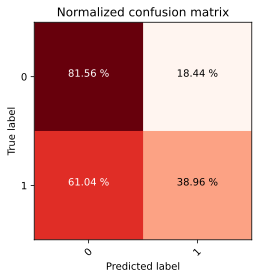

In [19]:
# матрица ошибок алгоритма. При хорошем прогнозе на главной диагонали будут стоять цифры, близкие к 100.
print('Общее число совпадений', accuracy_score(y_test, predicted_class))
print('Полнота охвата класса 1:', recall_score(y_test, predicted_class))
print('Точность:', precision_score(y_test, predicted_class))
plot_confusion_matrix(y_test, predicted_class, [0,1], normalize=True)

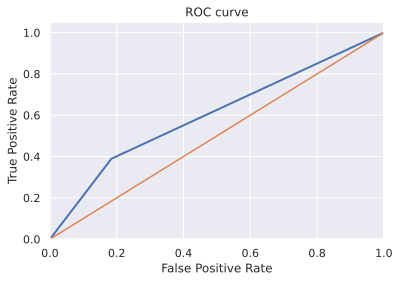

In [20]:
sns.set(font_scale=1)
sns.set_color_codes("muted")

plt.figure(figsize=(6, 4))
fpr, tpr, thresholds = roc_curve(y_test, predicted_class, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

надо разобраться как выбирать порог по вероятности

## FE with trees


In [21]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=42)

In [22]:
model = DecisionTreeClassifier(max_depth=40, min_samples_split=2)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

проблемы с отрисовкой после первой отрисовки

Общее число совпадений 0.7272
Полнота охвата класса 1: 0.33766233766233766
Точность: 0.3090822634331907


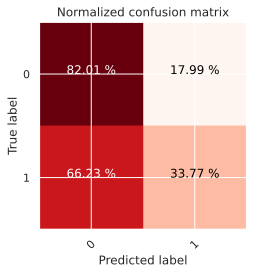

In [23]:
print('Общее число совпадений', accuracy_score(y_test, y_pred))
print('Полнота охвата класса 1:', recall_score(y_test, y_pred))
print('Точность:', precision_score(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, [0,1], normalize=True)